# HMM+Viterbi实现词性标注
1. 概率图模型
2. 贝叶斯网络
3. 马尔科夫模型
4. 隐马尔科夫模型
5. HMM应用之一：隐序列解码
6. Viterbi算法

## Probabilistic Graphical Model
**概率图模型**：利用图来表示与模型有关的变量的联合概率分布

## Bayesian Network
将随机变量作为结点，若两个随机变量相关或者不独立，则将二者连接一条边；若给定若干随机变量，则形成一个有向图，即构成一个<u>网络</u>。

如果该网络是`有向无环图`，则这个网络称为**贝叶斯网络**。

**e.g.**
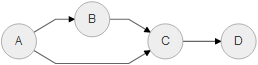
$p(A,B,C,D)=P(A)P(B|A)P(C|A,B)P(D|C)$

## Markov Model
若<u>贝叶斯网络</u>退化成`线性链`，则得到**马尔科夫模型**。

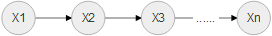

已知 $n$ 个有序随机变量，根据贝叶斯定理，其联合分布可写成条件分布的连乘
$$p(x_1,x_2,...x_n) = \prod_{i=1}^n p(x_i|x_{i-1},...x_1)$$

马尔科夫模型是指，假设序列中的任一随机变量只与它的前 $1$ 个变量有关，与更早的变量条件独立
$$p(x_i|x_{i-1},...x_1) = p(x_i|x_{i-1})$$

在此假设下，其联合分布可简化为
$$p(x_1,x_2,...x_n) = p(x_1) \prod_{i=2}^n p(x_i|x_{i-1})$$

为了表达当前变量与更早的变量之间的关系，可引入<u>高阶马尔科夫性</u>，指当前随机变量与它的前 $m$ 个变量有关
$$p(x_1,x_2,...x_n) = \prod_{i=1}^n p(x_i|x_{i-1},...x_{i-m})$$

## Hidden Markov Model

对于离散型随机变量
- 隐性序列：$Z=z_1,z_2,...z_n$
- 显性序列：$X=x_1,x_2,...x_n$

![](https://img-blog.csdnimg.cn/20190618094626159.png)

已知显性序列 $X$ ，求解最大概率的隐性序列 $Z$，即：最大化 $p(Z|X)$

$$p(Z|X)=p(X|Z)p(Z)= p(x_1,x_2,...x_n|z_1,z_2,...z_n) p(z_1,z_2,...z_n)$$

根据马尔科夫假设，任一随机变量只与它的前 $1$ 个变量有关

$$p(x_1,x_2,...x_n|z_1,z_2,...z_n)=\prod_{i=1}^np(x_i|z_i)$$

$$p(z_1,z_2,...z_n) = p(z_1) \prod_{i=2}^n p(z_i|z_{i-1})$$

模型简化为3个部分
1. **（隐态→显态）发射概率模型：**$\prod_{i=1}^np(x_i|z_i)$
2. **（隐态）初始概率模型：**$p(z_1)$
3. **（隐态）转移概率模型：**$\prod_{i=2}^n p(z_i|z_{i-1})$

## HMM预测解码问题

已知HMM的参数 $\lambda = (A,B,\pi)$ 和观测序列 $O = o_1,o_2, ..., o_t$ ，计算模型 $\lambda$ 下观测序列 $O$ 出现时最大可能的隐状态序列 $Z$

`HMM`+`Viterbi`实现`POS tagging`

#### 基础配置、语料准备

In [1]:
import numpy as np, pandas as pd

START = 'start'  # 句始tag
END = 'end'  # 句末tag
NOUN = 'subj'  # 名词
ADV = 'adv'  # 副词
ADJ = 'adj'  # 形容词

corpus = np.array([
    ('我', NOUN), ('很', ADV), ('菜', ADJ), ('。', END),
    ('我', NOUN), ('好', ADV), ('菜', ADJ), ('。', END),
    ('我', NOUN), ('很', ADV), ('好', ADJ), ('。', END),
    ('他', NOUN), ('很', ADV), ('菜', ADJ), ('。', END),
    ('他', NOUN), ('好', ADV), ('菜', ADJ), ('。', END),
    ('他', NOUN), ('很', ADV), ('好', ADJ), ('。', END),
    ('菜', NOUN), ('很', ADV), ('好', ADJ), ('。', END),
    ('我', NOUN), ('菜', ADJ), ('。', END),
    ('我', NOUN), ('好', ADJ), ('。', END),
    ('他', NOUN), ('菜', ADJ), ('。', END),
    ('他', NOUN), ('好', ADJ), ('。', END),
    ('菜', NOUN), ('好', ADJ), ('。', END),
    ('我', NOUN), ('好', ADV), ('好', ADJ), ('。', END),
    ('他', NOUN), ('好', ADV), ('好', ADJ), ('。', END),
], dtype=str)

words = sorted(set(corpus[:, 0]))
tags = sorted(set(corpus[:, 1]))

W = len(words)  # 词汇量
T = len(tags)   # 词性种类数

word2id = {words[i]: i for i in range(W)}
tag2id = {tags[i]: i for i in range(T)}
id2tag = {i: tags[i] for i in range(T)}

#### HMM参数训练

In [2]:
SMOOTHNESS = 1e-8  # 平滑参数

emit_p = np.zeros((T, W)) + SMOOTHNESS  # emission_probability
start_p = np.zeros(T) + SMOOTHNESS  # start_probability
trans_p = np.zeros((T, T)) + SMOOTHNESS  # transition_probability

prev_tag = START  # 前一个tag
for word, tag in corpus:
    wid, tid = word2id[word], tag2id[tag]
    emit_p[tid][wid] += 1
    if prev_tag == START:
        start_p[tid] += 1
    else:
        trans_p[tag2id[prev_tag]][tid] += 1
    prev_tag = START if tag == END else tag  # 句尾判断

#### 取对数，防止下溢，乘法运算转换成更简单的加法运算
$$\sum_{i=1}^n \ln p(x_i|z_i) + \ln p(z_1) + \sum_{i=2}^n \ln p(z_i|z_{i-1})$$

In [3]:
# 频数 --> 概率对数
start_p = np.log(start_p / sum(start_p))
for i in range(T):
    emit_p[i] = np.log(emit_p[i] / sum(emit_p[i]))
    trans_p[i] = np.log(trans_p[i] / sum(trans_p[i]))

#### 隐→显 发射矩阵

In [4]:
pd.DataFrame(start_p.reshape(1, T), ['START'], tags)

,adj,adv,end,subj
START,-21.059738,-21.059738,-21.059738,-2.142857e-09


#### 初始隐态矩阵

In [5]:
pd.DataFrame(start_p.reshape(1, T), ['START'], tags)

,adj,adv,end,subj
START,-21.059738,-21.059738,-21.059738,-2.142857e-09


#### 隐态转移矩阵

In [6]:
pd.DataFrame(trans_p, tags, tags)

,adj,adv,end,subj
adj,-2.105974e+01,-21.059738,-2.142857e-09,-21.059738
adv,-3.333334e-09,-20.617905,-2.061791e+01,-20.617905
end,-1.386294e+00,-1.386294,-1.386294e+00,-1.386294
subj,-1.029619e+00,-0.441833,-2.105974e+01,-21.059738


#### 待测句子

In [7]:
sentence = list('菜好好。')

#### Viterbi

In [8]:
obs = [word2id[w] for w in sentence]  # 观测序列
le = len(obs)  # 序列长度

# 动态规划矩阵
dp = np.array([[-1e99] * T] * le)  # 节点最大概率对数
path = np.zeros((le, T), dtype=int)  # 节点转移记录

for j in range(T):
    dp[0][j] = start_p[j] + emit_p[j][obs[0]]
    path[0][j] = -1

for i in range(1, le):
    for j in range(T):
        dp[i][j], path[i][j] = max(
            (dp[i - 1][k] + trans_p[k][j] + emit_p[j][obs[i]], k)
            for k in range(T))

#### 节点最大概率矩阵

In [9]:
pd.DataFrame(dp.T, tags, sentence)

,菜,好,好,。
adj,-21.907036,-3.535145,-3.758289,-45.687247
adv,-41.677643,-3.198673,-24.627509,-45.435932
end,-42.119476,-42.966774,-24.594883,-3.758289
subj,-1.945910,-44.065386,-44.876317,-45.877765


#### 节点转移记录矩阵

In [10]:
pd.DataFrame(path.T, tags, sentence)

,菜,好,好,。
adj,-1,3,1,1
adv,-1,3,1,0
end,-1,0,0,0
subj,-1,3,1,0


#### 隐态序列标号

In [11]:
states = [np.argmax(dp[le - 1])]
# 从后到前的循环来依次求出每个单词的词性
for i in range(le - 2, -1, -1):
    states.insert(0, path[i + 1][states[0]])
states

[3, 1, 0, 2]

#### 最终结果打印

In [12]:
for word, tid in zip(sentence, states):
    print(word, id2tag[tid])

菜 subj
好 adv
好 adj
。 end


### 补充：马尔科夫网络、马尔科夫模型、马尔科夫过程、贝叶斯网络的区别
1. 将随机变量作为结点，若两个随机变量相关或者不独立，则将二者连接一条边；若给定若干随机变量，则形成一个有向图，即构成一个网络。
2. 如果该网络是有向无环图，则这个网络称为`贝叶斯网络`。
3. 如果这个图退化成线性链的方式，则得到`马尔科夫模型`；因为每个结点都是随机变量，将其看成各个时刻(或空间)的相关变化，以随机过程的视角，则可以看成是`马尔科夫过程`。
4. 若上述网络是无向的，则是无向图模型，又称`马尔科夫随机场`。
5. 如果在给定某些条件的前提下，研究这个马尔科夫随机场，则得到`条件随机场`。
6. 如果使用条件随机场解决标注问题，并且进一步将条件随机场中的网络拓扑变成线性的，则得到`线性链条件随机场`。